# Określanie płci na podstawie analizy obrazu

# Importy

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras import callbacks

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content')
os.getcwd()

'/content'

### zbiór CelebA Dataset

In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/celeba-dataset.zip"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_a

In [5]:
! mkdir /content/train
! mkdir /content/test
! mkdir /content/valid

In [6]:
! mkdir /content/train/male
! mkdir /content/train/female
! mkdir /content/test/male
! mkdir /content/test/female
! mkdir /content/valid/male
! mkdir /content/valid/female

# Analiza danych

In [7]:
df1 = pd.read_csv('list_attr_celeba.csv')
df2 = pd.read_csv('list_bbox_celeba.csv')
df3 = pd.read_csv('list_eval_partition.csv')
df4 = pd.read_csv('list_landmarks_align_celeba.csv')

In [8]:
img_list = df1['image_id']

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [10]:
print("Number of rows in the data:", df1.shape[0])
print("Number of columns in the data:", df1.shape[1])

Number of rows in the data: 202599
Number of columns in the data: 41


In [11]:
df1.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**Zamiana wartości -1 na 0**

- 0 - oznacza Kobietę
- 1 - oznacza Meżczyznę

In [12]:
df1.replace(-1,0,inplace=True)
df1['Male'].replace(0,'K',inplace=True)
df1['Male'].replace(1,'M',inplace=True)
df1

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
202595,202596.jpg,0,0,0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0,0,1
202596,202597.jpg,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
202597,202598.jpg,0,1,1,0,0,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1


In [13]:
df1_drop_imageID = df1.drop(['image_id'], axis=1)
cols = df1_drop_imageID.columns

In [14]:
for col in cols:
  print(df1_drop_imageID[col].value_counts())

0    180083
1     22516
Name: 5_o_Clock_Shadow, dtype: int64
0    148509
1     54090
Name: Arched_Eyebrows, dtype: int64
1    103833
0     98766
Name: Attractive, dtype: int64
0    161153
1     41446
Name: Bags_Under_Eyes, dtype: int64
0    198052
1      4547
Name: Bald, dtype: int64
0    171890
1     30709
Name: Bangs, dtype: int64
0    153814
1     48785
Name: Big_Lips, dtype: int64
0    155083
1     47516
Name: Big_Nose, dtype: int64
0    154127
1     48472
Name: Black_Hair, dtype: int64
0    172616
1     29983
Name: Blond_Hair, dtype: int64
0    192287
1     10312
Name: Blurry, dtype: int64
0    161027
1     41572
Name: Brown_Hair, dtype: int64
0    173796
1     28803
Name: Bushy_Eyebrows, dtype: int64
0    190936
1     11663
Name: Chubby, dtype: int64
0    193140
1      9459
Name: Double_Chin, dtype: int64
0    189406
1     13193
Name: Eyeglasses, dtype: int64
0    189883
1     12716
Name: Goatee, dtype: int64
0    194100
1      8499
Name: Gray_Hair, dtype: int64
0    124209
1    

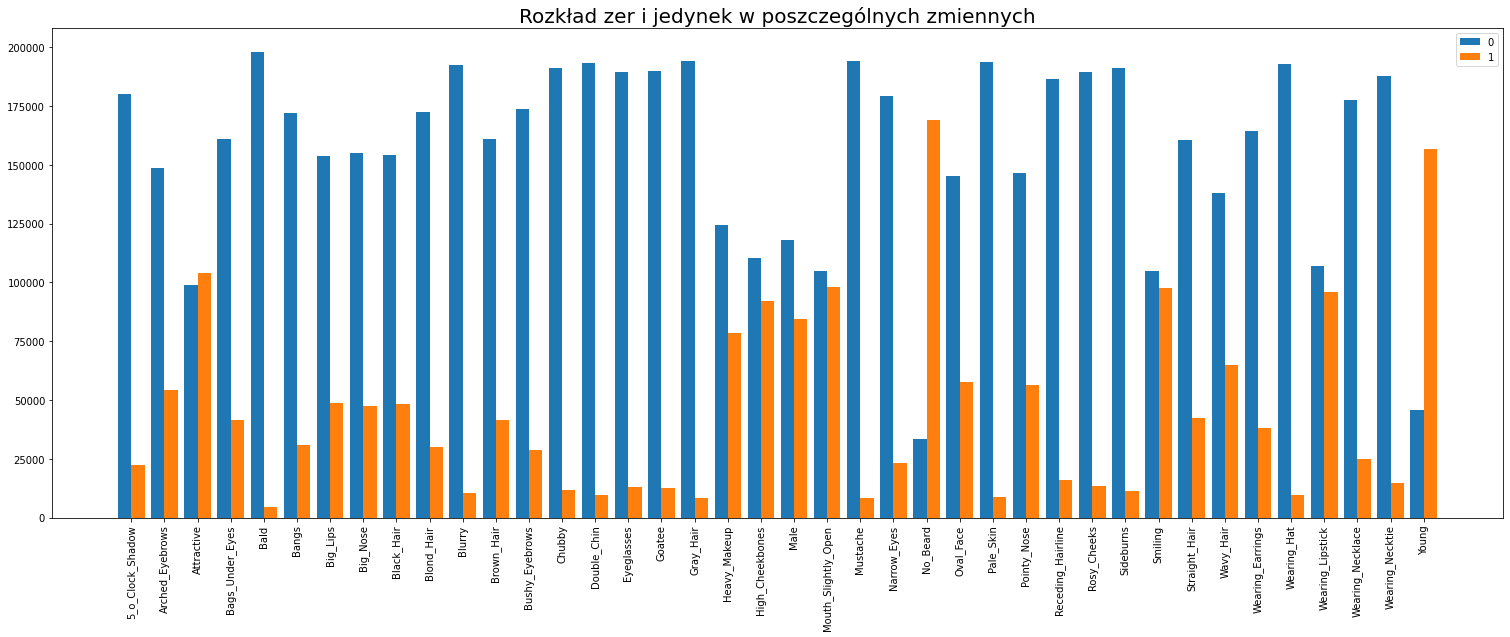

In [15]:
fig, ax = plt.subplots(figsize=(26, 9))
width = 0.4
labels = cols
index = np.arange(len(labels))
zeros = []
ones = []
for col in cols:
  a = df1_drop_imageID[col].value_counts()
  zeros.append(a[0])
  ones.append(a[1])
plt.bar(index - width/2, zeros, width, label='0')
plt.bar(index + width/2, ones, width, label='1')
plt.xticks(index, labels)
plt.xticks(rotation = 90)
plt.legend()
plt.title('Rozkład zer i jedynek w poszczególnych zmiennych',size=20 )
plt.show()

In [16]:
df1_counts = df1.Male.value_counts()
df1_counts

K    118165
M     84434
Name: Male, dtype: int64

Lista dostępnych atrybutów w zbiorze danych CelebA

In [17]:
for i, j in enumerate(df1.columns):
    print(i, j)

0 image_id
1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young


Wyświetlenie pierwszego zdjęcia

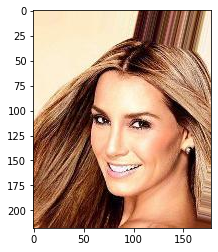

In [18]:
img = cv2.imread('img_align_celeba/img_align_celeba/'+img_list[0])
n_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(n_img)

In [19]:
n_img.shape

(218, 178, 3)

Wyświetlenie ośmiu losowo wybranych zdjęć

img_align_celeba/img_align_celeba/030376.jpg


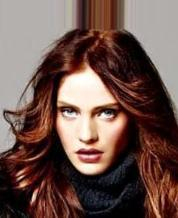

img_align_celeba/img_align_celeba/200329.jpg


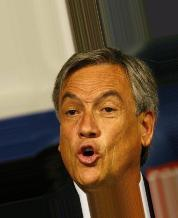

img_align_celeba/img_align_celeba/027523.jpg


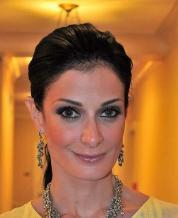

img_align_celeba/img_align_celeba/074762.jpg


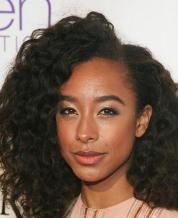

img_align_celeba/img_align_celeba/033018.jpg


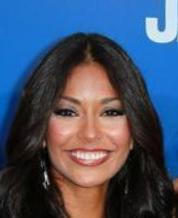

img_align_celeba/img_align_celeba/008016.jpg


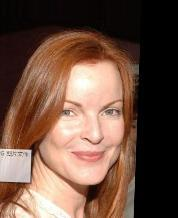

img_align_celeba/img_align_celeba/066297.jpg


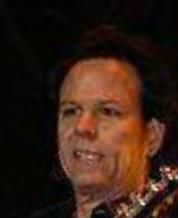

img_align_celeba/img_align_celeba/098185.jpg


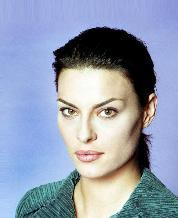

In [20]:
rand_pics = random.choices(df1['image_id'], k = 8)

def show_image(img):
  cv2_imshow(cv2.imread(img))
for pic in rand_pics:
  img='img_align_celeba/img_align_celeba/'+pic
  print(img)
  show_image(img)

### Porównanie zawartości zbioru

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


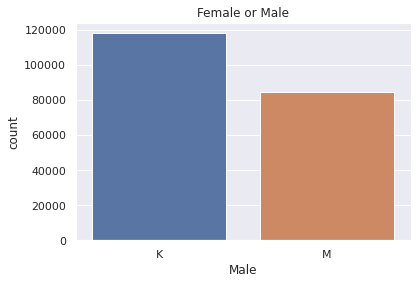

In [21]:
sns.set_theme(style="darkgrid")
sns.countplot(df1['Male'], data=df1)
plt.title('Female or Male')
plt.show()

W zbiorze danych jest więcej kobiet niż mężczyzn.

## Partycjonowanie obrazów na zestawy uczące, walidacyjne, testowe. 

Obrazy 1-162770 to trenowanie, 162771-182637 to
walidacja, 182638-202599 to testy

    1-162770 train
    162771-182637 valid
    182638-202599 test


In [22]:
df1_1 = pd.read_csv('list_attr_celeba.csv')
import shutil
for i in range(0,162771):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/train/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/train/female')
for i in range(162771,182638):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/valid/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/valid/female')
for i in range(182638,len(img_list)):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/test/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/test/female')

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [24]:
train_generator = train_datagen.flow_from_directory('/content/train/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory('/content/valid/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')

test_generator = test_datagen.flow_from_directory('/content/test/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')


Found 162771 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19961 images belonging to 2 classes.


Budowanie modelu Sekwencyjnego

In [25]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(124,100,3),kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 25, 64)       0         
 2D)                                                    

In [26]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9)
model.compile(optimizer=opt,
              loss='mae',
              metrics=['accuracy'])

In [27]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    patience=1,
    min_delta=0.001,
    restore_best_weights=True,
) 

In [28]:
batch_size = 512
history = model.fit(
    train_generator,
    steps_per_epoch = 162771 / batch_size,
    validation_steps = 19867 / batch_size,
    epochs=20,
    batch_size = batch_size,
    # y=valid_generator,
    validation_data=valid_generator,
    callbacks=[early_stopping])

Epoch 1/20
317/317 [==============================] - 1176s 4s/step - loss: 0.4156 - accuracy: 0.5843 - val_loss: 0.4358 - val_accuracy: 0.5569
Epoch 2/20
317/317 [==============================] - 1175s 4s/step - loss: 0.2691 - accuracy: 0.7537 - val_loss: 0.1846 - val_accuracy: 0.8349
Epoch 3/20
317/317 [==============================] - 1168s 4s/step - loss: 0.1657 - accuracy: 0.8489 - val_loss: 0.1106 - val_accuracy: 0.9075
Epoch 4/20
317/317 [==============================] - 1180s 4s/step - loss: 0.1129 - accuracy: 0.9014 - val_loss: 0.1053 - val_accuracy: 0.9050
Epoch 5/20
317/317 [==============================] - 1186s 4s/step - loss: 0.0914 - accuracy: 0.9192 - val_loss: 0.0726 - val_accuracy: 0.9407
Epoch 6/20
317/317 [==============================] - 1177s 4s/step - loss: 0.0806 - accuracy: 0.9274 - val_loss: 0.0635 - val_accuracy: 0.9435
Epoch 7/20
317/317 [==============================] - 1184s 4s/step - loss: 0.0744 - accuracy: 0.9322 - val_loss: 0.0635 - val_accuracy:

In [29]:
test_accuracy_model = model.evaluate(test_generator)[1]

312/312 [==============================] - 288s 923ms/step - loss: 0.0701 - accuracy: 0.9368


In [30]:
print(f'dokładność na zbiorze testowym: {round(test_accuracy_model, 4)}')

dokładność na zbiorze testowym: 0.9368


## Wnioski

Minimum Validation Loss: 0.0635


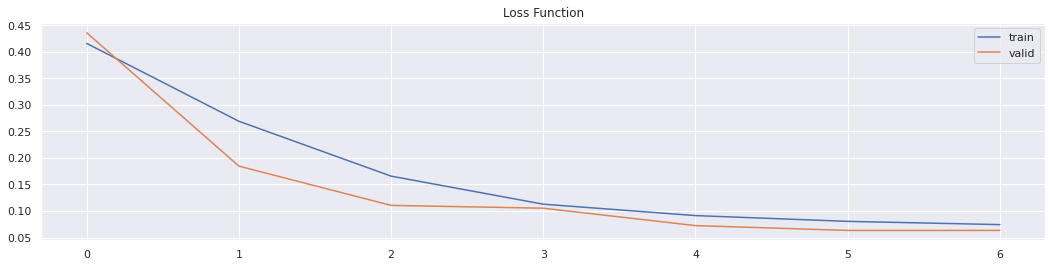

In [31]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
history_df = pd.DataFrame(history.history)
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
plt.show()

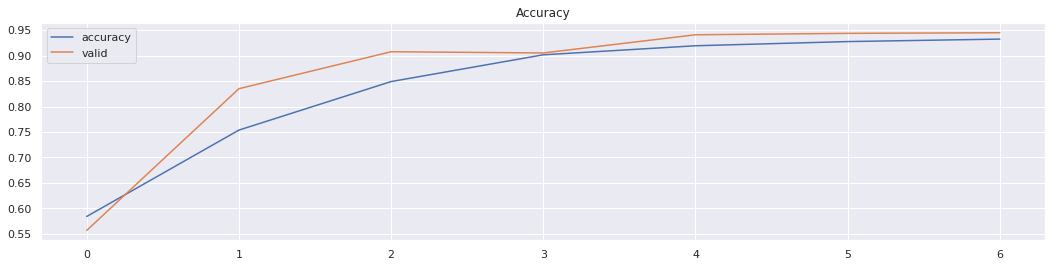

In [32]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

## Rozpoznawanie płci na przykładowych zdjęciach

In [33]:
def gender_prediction(filename):
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (100, 124)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    return result

In [34]:
df_to_test = df3[(df3['partition'] == 2)].sample(8)

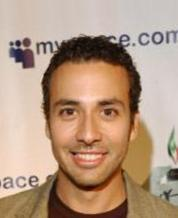

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [0.9999585]
Płeć według danych atrybutów:  187051    M
Name: Male, dtype: object
 


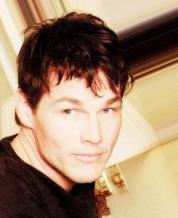

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [0.9597793]
Płeć według danych atrybutów:  198931    M
Name: Male, dtype: object
 


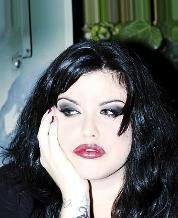

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [8.442759e-06]
Płeć według danych atrybutów:  187822    K
Name: Male, dtype: object
 


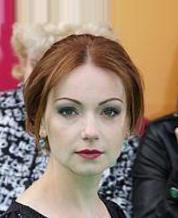

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [0.00010331]
Płeć według danych atrybutów:  194762    K
Name: Male, dtype: object
 


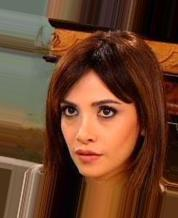

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [9.0481103e-07]
Płeć według danych atrybutów:  196360    K
Name: Male, dtype: object
 


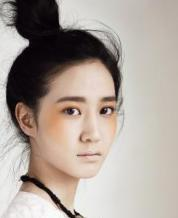

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [0.06930545]
Płeć według danych atrybutów:  188216    K
Name: Male, dtype: object
 


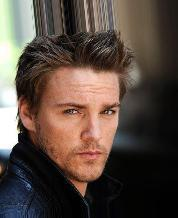

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [0.96383417]
Płeć według danych atrybutów:  193090    M
Name: Male, dtype: object
 


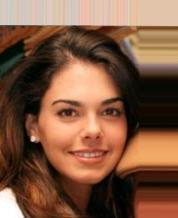

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [3.3473572e-07]
Płeć według danych atrybutów:  186538    K
Name: Male, dtype: object
 


In [35]:
for index, target in df_to_test.iterrows():
    result = gender_prediction('img_align_celeba/img_align_celeba/'+target[0])
    show_image('img_align_celeba/img_align_celeba/'+target[0])
    print(f'Prawdopodobieństwo, że na zdjęciu jest mężczyzna: ', result[0])
    print(f'Płeć według danych atrybutów: ', df1['Male'].loc[df1['image_id']==target[0]])
    print(' ')

## Rozpoznawanie naszych zdjęć

In [36]:
! mkdir /content/drive/MyDrive/our_photos

mkdir: cannot create directory ‘/content/drive/MyDrive/our_photos’: File exists


In [37]:
os.chdir('/content/drive/MyDrive/our_photos')

In [38]:
df5=['photo_Mateusz.png', 'photo_Iza.png', 'photo_Agnieszka.png']

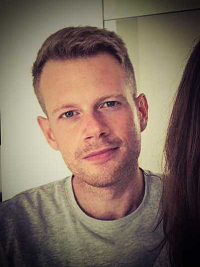

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.99998134]]
 


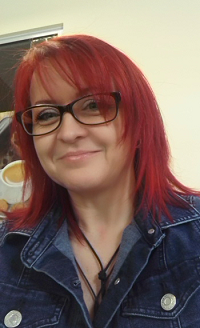

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.99884474]]
 


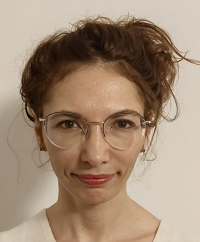

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.00089398]]
 


In [39]:
for photo in df5:
    result = gender_prediction(photo)
    show_image(photo)
    print(f'Prawdopodobieństwo, że na zdjęciu jest mężczyzna: ', result)
    print(' ')